In [2]:
getwd()

[1] "/Users/evergreen/Desktop/ABC"

In [3]:
library("abcrf")

In [4]:
version

               _                           
platform       x86_64-apple-darwin15.6.0   
arch           x86_64                      
os             darwin15.6.0                
system         x86_64, darwin15.6.0        
status                                     
major          3                           
minor          5.2                         
year           2018                        
month          12                          
day            20                          
svn rev        75870                       
language       R                           
version.string R version 3.5.2 (2018-12-20)
nickname       Eggshell Igloo              

In [5]:
R.home() #using non-anaconda build, which is more stable

[1] "/Library/Frameworks/R.framework/Resources"

In [6]:
abcrf:::abcrf.formula

function (formula, data, group = list(), lda = TRUE, ntree = 500, 
    sampsize = min(1e+05, nrow(data)), paral = FALSE, ncores = if (paral) max(detectCores() - 
        1, 1) else 1, ...) 
{
    if (!inherits(formula, "formula")) 
        stop("abcrf.formula is only for formula objects")
    if (!inherits(data, "data.frame")) 
        stop("data needs to be a data.frame object")
    if (is.na(ncores)) {
        warning("Unable to automatically detect the number of CPU cores, \n1 CPU core will be used or please specify ncores.")
        ncores <- 1
    }
    if ((!is.logical(paral)) || (length(paral) != 1L)) 
        stop("paral should be TRUE or FALSE")
    if (!is.list(group)) 
        stop("group needs to be a list")
    mf <- match.call(expand.dots = FALSE)
    m <- match(c("formula", "data"), names(mf))
    mf <- mf[c(1L, m)]
    mf[[1L]] <- as.name("model.frame")
    mf <- eval(mf, parent.frame())
    if (!is.factor(model.response(mf))) 
        stop("response should be a factor containing the model indexes")
    if (nrow(data) == 0L || is.null(nrow(data))) 
        stop("no simulation in the reference table (response, sumstat)")
    if ((!is.logical(lda)) && (length(lda) != 1L)) 
        stop("lda should be TRUE or FALSE")
    if (length(group) != 0) {
        ngroup <- length(group)
        varn <- formula[[2]]
        data[[as.character(varn)]] <- as.vector(data[[as.character(varn)]])
        allmod <- unique(data[[as.character(varn)]])
        for (k in 1:ngroup) for (l in 1:length(group[[k]])) data[[as.character(varn)]][which(data[[as.character(varn)]] == 
            group[[k]][l])] <- paste("g", k, sep = "")
        if (!setequal(allmod, unlist(group))) {
            diffe <- setdiff(allmod, unlist(group))
            for (l in 1:length(diffe)) data <- data[-which(data[[as.character(varn)]] == 
                diffe[l]), ]
        }
        data[[as.character(varn)]] <- as.factor(data[[as.character(varn)]])
    }
    if (lda) {
        model.lda <- lda(formula, data)
        data <- cbind(data, as.matrix(predict(model.lda, data)$x))
    }
    else {
        model.lda <- NULL
    }
    m <- names(match.call(expand.dots = TRUE))
    if ((!"sampsize" %in% m) && (nrow(data) <= 15)) 
        sampsize <- as.integer(sampsize/10)
    if (sampsize > nrow(data)) 
        stop("sampsize too large")
    model.rf <- ranger(formula, data, num.trees = ntree, sample.fraction = sampsize/nrow(data), 
        num.threads = ncores, keep.inbag = TRUE, importance = "impurity", 
        ...)
    class.error = vector()
    for (i in 1:nrow(model.rf$confusion.matrix)) {
        rowSum <- sum(model.rf$confusion.matrix[i, ])
        accurate <- diag(model.rf$confusion.matrix)[i]
        error <- rowSum - accurate
        class.error[i] <- error/rowSum
    }
    model.rf$confusion.matrix <- cbind(model.rf$confusion.matrix, 
        class.error)
    colnames(model.rf$confusion.matrix) <- c(paste(model.rf$forest$levels), 
        "class.error")
    model.rf$model.rf
    cl <- match.call()
    cl[[1]] <- as.name("abcrf")
    x <- list(call = cl, lda = lda, formula = formula, group = group, 
        model.rf = model.rf, model.lda = model.lda, prior.err = model.rf$prediction.error)
    class(x) <- "abcrf"
    x
}
<bytecode: 0x7fa895b54618>
<environment: namespace:abcrf>

# abcrf demo

In [9]:
data(snp)
modindex <- snp$modindex[1:500]
sumsta <- snp$sumsta[1:500,]
data1 <- data.frame(modindex, sumsta)
model.rf1 <- abcrf(modindex~., data = data1, ntree=100)
model.rf1


Call:
 abcrf(formula = modindex ~ ., data = data1, ntree = 100) 
includes the axes of a preliminary LDA

Number of simulations: 1
Out-of-bag prior error rate: 23%

Confusion matrix:
    1   2   3 class.error
1 156   5  23   0.1521739
2   6 123  22   0.1854305
3  29  30 106   0.3575758

In [10]:
model.rf2 <- abcrf(modindex~., data = data1, group = list(c("1","2"),"3"), ntree=100)
model.rf2


Call:
 abcrf(formula = modindex ~ ., data = data1, group = list(c("1", "2"), "3"), ntree = 100) 
includes the axes of a preliminary LDA

Number of simulations: 1
Out-of-bag prior error rate: 20.6%

Confusion matrix:
    g1 g2 class.error
g1 303 32  0.09552239
g2  71 94  0.43030303

# RF

In [11]:
require(ranger)

## Classification forest with default settings
ranger(Species ~ ., data = iris)

Ranger result

Call:
 ranger(Species ~ ., data = iris) 

Type:                             Classification 
Number of trees:                  500 
Sample size:                      150 
Number of independent variables:  4 
Mtry:                             2 
Target node size:                 1 
Variable importance mode:         none 
Splitrule:                        gini 
OOB prediction error:             4.00 % 

In [12]:
## Prediction
train.idx <- sample(nrow(iris), 2/3 * nrow(iris))
iris.train <- iris[train.idx, ]
iris.test <- iris[-train.idx, ]
rg.iris <- ranger(Species ~ ., data = iris.train)
pred.iris <- predict(rg.iris, data = iris.test)
table(iris.test$Species, pred.iris$predictions)

            
             setosa versicolor virginica
  setosa         16          0         0
  versicolor      0         17         2
  virginica       0          3        12

In [13]:
## Quantile regression forest
rf <- ranger(mpg ~ ., mtcars[1:26, ], quantreg = TRUE)
pred <- predict(rf, mtcars[27:32, ], type = "quantiles")
pred$predictions

quantile= 0.1,quantile= 0.5,quantile= 0.9
21.0,22.8,33.9
21.0,22.8,32.4
13.3,15.5,27.3
15.5,21.0,22.8
13.3,14.3,19.2
21.0,22.8,32.4


In [14]:
## Variable importance
rg.iris <- ranger(Species ~ ., data = iris, importance = "impurity")
rg.iris$variable.importance

Sepal.Length  Sepal.Width Petal.Length  Petal.Width 
    9.588822     2.088869    43.629087    43.973003

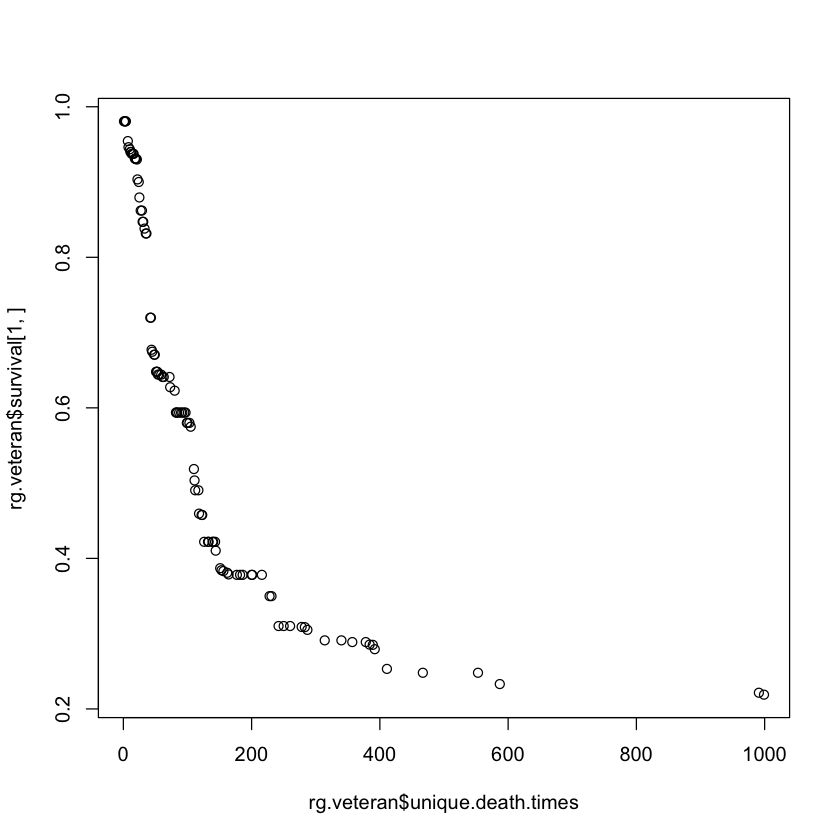

In [15]:
## Survival forest
require(survival)
rg.veteran <- ranger(Surv(time, status) ~ ., data = veteran)
plot(rg.veteran$unique.death.times, rg.veteran$survival[1,])

In [16]:
## Alternative interface
ranger(dependent.variable.name = "Species", data = iris)

Ranger result

Call:
 ranger(dependent.variable.name = "Species", data = iris) 

Type:                             Classification 
Number of trees:                  500 
Sample size:                      150 
Number of independent variables:  4 
Mtry:                             2 
Target node size:                 1 
Variable importance mode:         none 
Splitrule:                        gini 
OOB prediction error:             4.00 % 

In [18]:
# ## Not run: 
# ## Use GenABEL interface to read Plink data into R and grow a classification forest
# ## The ped and map files are not included
# library(GenABEL)
# convert.snp.ped("data.ped", "data.map", "data.raw")
# dat.gwaa <- load.gwaa.data("data.pheno", "data.raw")
# phdata(dat.gwaa)$trait <- factor(phdata(dat.gwaa)$trait)
# ranger(trait ~ ., data = dat.gwaa)

# ## End(Not run)